In [2]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree, cophenet, fcluster
from scipy.spatial.distance import pdist, squareform, cdist
from mpl_toolkits.mplot3d import Axes3D  # for 3D plots
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
#Libraries
import statsmodels.api as sm
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [3]:
#Load df
CREDIT_PATH = 'credit_default.csv'
df = pd.read_csv(CREDIT_PATH)
df

#separate X and y
X = df.drop('default', axis=1) #all numerical features
y = df['default'] #target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) #split df into train-test

#scale the values
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)


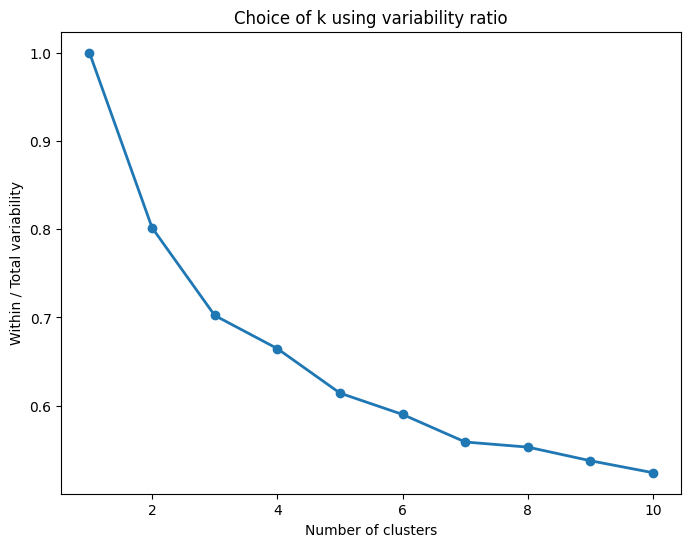

In [4]:
#Clustering
#Variability Ratio (looks for minimal => elbow method)
w = []
b = []

#the object X must already be a numpy array
X_train = np.array(X_train)
totss = np.sum((X_train - X_train.mean(axis=0))**2)

# try num of clusters= 1,3,...10

for k_val in range(1, 11):
    km = KMeans(n_clusters=k_val, random_state=42).fit(X_train)
    withinss = km.inertia_ # WSS
    between_ss = totss - withinss
    w.append(withinss)
    b.append(between_ss)

ratio = np.array(w) / (np.array(w) + np.array(b))
plt.figure(figsize=(8,6))
plt.plot(range(1, 11), ratio, marker='o', linewidth=2)
plt.xlabel("Number of clusters")
plt.ylabel("Within / Total variability")
plt.title("Choice of k using variability ratio")
plt.show()

In [5]:
#Silhouette scores when number of cluster varies
from sklearn.metrics import silhouette_score

#Optimal number of clusters selected using elbow method

optimal_num_clusters = 3
optimal_kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
cluster_labels = optimal_kmeans.fit_predict(X_train) #predict the cluster labels of the TRAINING SET


silhouette_avg = silhouette_score(X_train, cluster_labels)
print("For n_clusters =",optimal_num_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.15427420648827556


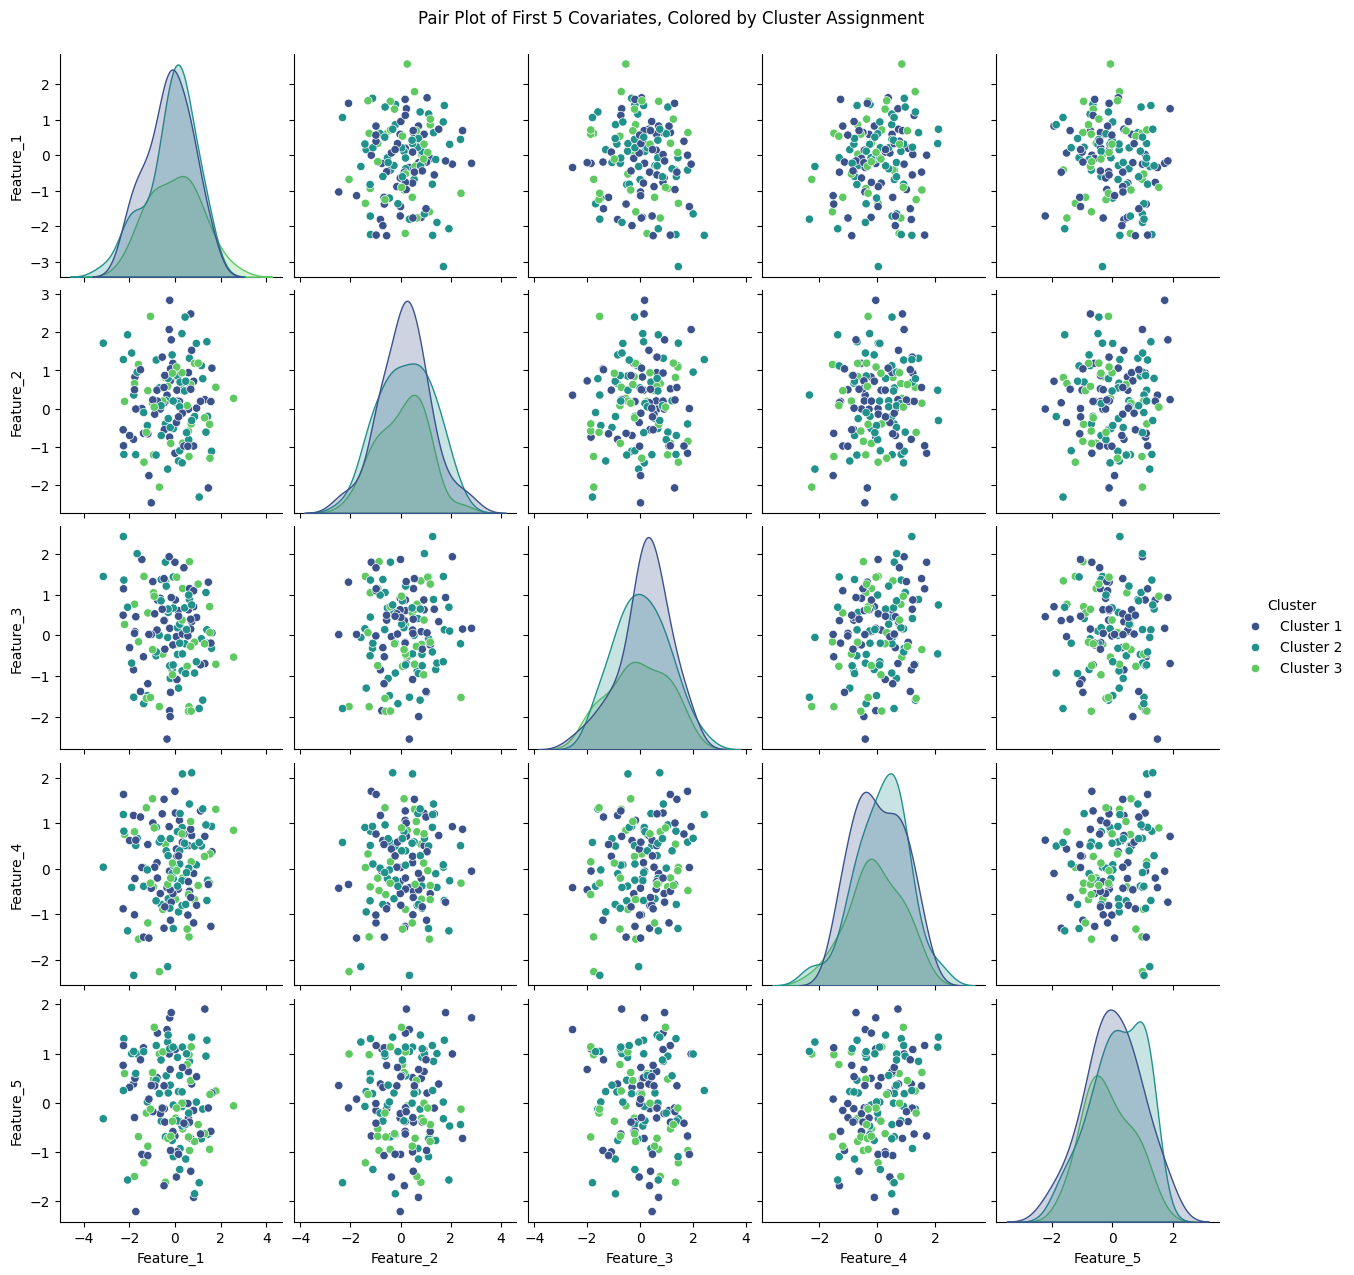

In [6]:
#visualize the clusters using pairplot
features_to_plot = X_train[:, :5]

# Create a Pandas DataFrame from these features
# It's good practice to name the columns for clearer plot labels
feature_names = [f'Feature_{i+1}' for i in range(features_to_plot.shape[1])]
df_plot = pd.DataFrame(features_to_plot, columns=feature_names)

# Add the cluster labels as a new column. This is crucial for coloring.
df_plot['Cluster'] = cluster_labels

# To make the cluster labels more intuitive (e.g., Cluster 1, 2, 3)
df_plot['Cluster'] = df_plot['Cluster'].astype('category')
df_plot['Cluster'] = df_plot['Cluster'].cat.rename_categories(['Cluster 1', 'Cluster 2', 'Cluster 3'])

# Create the pair plot
pair_plot = sns.pairplot(
    df_plot,
    hue='Cluster',
    palette='viridis', # A nice color palette for distinct clusters
    diag_kind='kde'    # Shows density plots on the diagonal
)

# Add a title to the entire plot
pair_plot.fig.suptitle("Pair Plot of First 5 Covariates, Colored by Cluster Assignment", y=1.02) # y=1.02 raises title

# Show the plot
plt.show()

In [7]:
#now let's divide the training dataset into k-subsets using the cluster labels
mask_cluster_1 = cluster_labels == 0
mask_cluster_2 = cluster_labels == 1
mask_cluster_3 = cluster_labels == 2


#divide the dataset into k subdatasets according to the mask
X_train_cluster1 = X_train[mask_cluster_1]
y_train_cluster1 = y_train[mask_cluster_1]

X_train_cluster2 = X_train[mask_cluster_2]
y_train_cluster2 = y_train[mask_cluster_2]

X_train_cluster3 = X_train[mask_cluster_3]
y_train_cluster3 = y_train[mask_cluster_3]

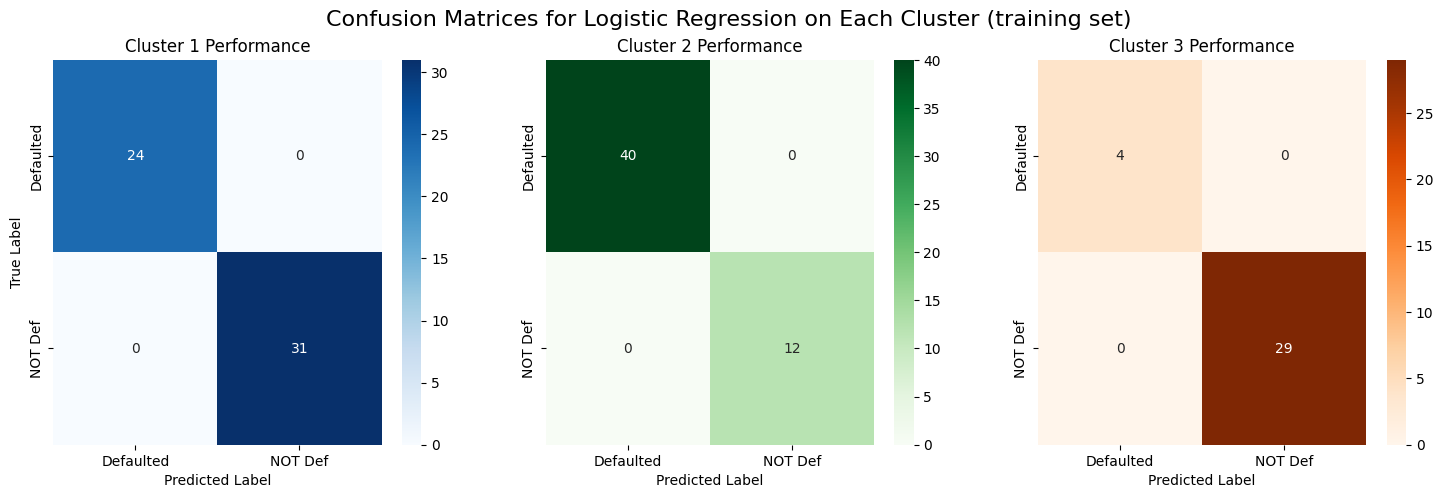

In [8]:
#for every sub-dataset we fit a LogisticRegression
#use a large C to avoid penalties
logistic_reg1 = LogisticRegression(penalty = 'l2',C=1e8)
logistic_reg1.fit(X_train_cluster1, y_train_cluster1)

logistic_reg2 = LogisticRegression(penalty = 'l2',C=1e8)
logistic_reg2.fit(X_train_cluster2, y_train_cluster2)

logistic_reg3 = LogisticRegression(penalty='l2',C=1e8)
logistic_reg3.fit(X_train_cluster3, y_train_cluster3)


#Let's plot the confusion matrix for each sub-logreg
y_fitted1 = logistic_reg1.predict(X_train_cluster1) #already labels
y_fitted2 = logistic_reg2.predict(X_train_cluster2)
y_fitted3 = logistic_reg3.predict(X_train_cluster3)


#Confusion Matrix
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_train_cluster1, y_fitted1)
cm2 = confusion_matrix(y_train_cluster2, y_fitted2)
cm3 = confusion_matrix(y_train_cluster3, y_fitted3)


# 1. Create a figure and a set of subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Define class names for the labels
class_names = ['Defaulted', 'NOT Def']
plot_titles = ['Cluster 1 Performance', 'Cluster 2 Performance', 'Cluster 3 Performance']

# 2. Plot each confusion matrix on its corresponding subplot
# Plot for Cluster 1
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, ax=axs[0])
axs[0].set_title(plot_titles[0])
axs[0].set_xlabel("Predicted Label")
axs[0].set_ylabel("True Label")

# Plot for Cluster 2
sns.heatmap(cm2, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names, ax=axs[1])
axs[1].set_title(plot_titles[1])
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("") # Hide y-label for cleaner look

# Plot for Cluster 3
sns.heatmap(cm3, annot=True, fmt="d", cmap="Oranges",
            xticklabels=class_names, yticklabels=class_names, ax=axs[2])
axs[2].set_title(plot_titles[2])
axs[2].set_xlabel("Predicted Label")
axs[2].set_ylabel("") # Hide y-label for cleaner look


# 3. Add a main title for the whole figure
fig.suptitle('Confusion Matrices for Logistic Regression on Each Cluster (training set)', fontsize=16)


# 4. Show the final plot
plt.show()

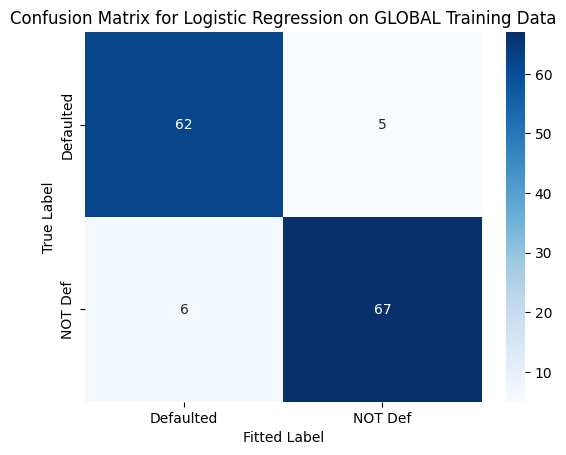

In [9]:
#Plot of the unique LogReg
logistic_reg_global = LogisticRegression()
logistic_reg_global.fit(X_train, y_train)

y_fitted_global = logistic_reg_global.predict(X_train)
cm_global = confusion_matrix(y_fitted_global,y_train)
sns.heatmap(cm_global, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Logistic Regression on GLOBAL Training Data')
plt.xlabel("Fitted Label")
plt.ylabel("True Label")
plt.show()

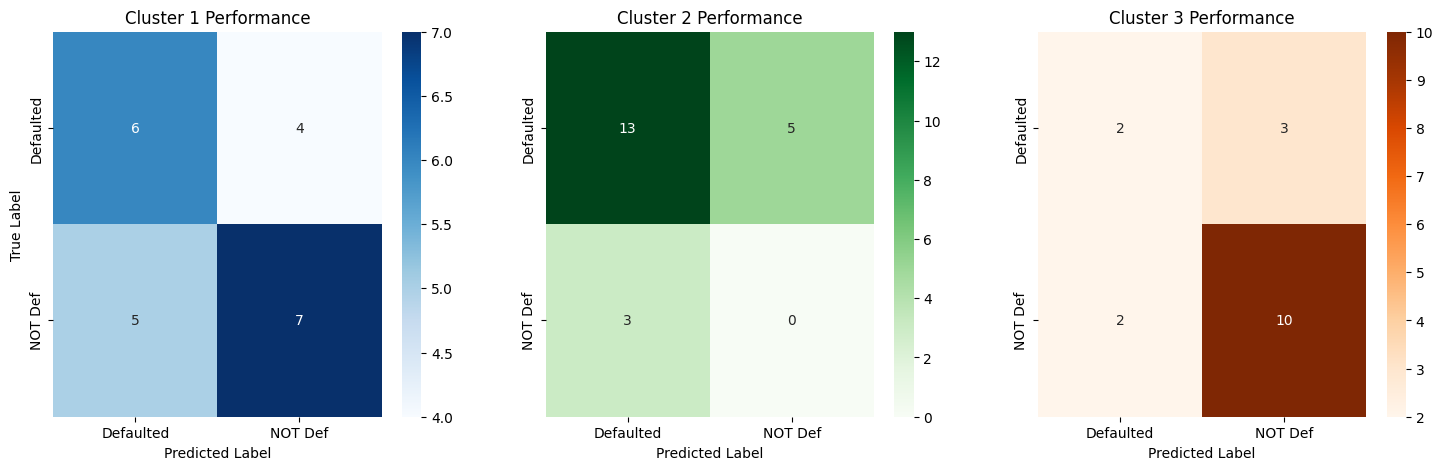

accuracy on cluster 1:  0.5909090909090909
accuracy on cluster 2:  0.6190476190476191
accuracy on cluster 3:  0.7058823529411765


In [10]:
#now let's predict the new assignments (test set)
#using the clustering-model fitted before, we predict the clustering assigment for X_test
cluster_labels_test = optimal_kmeans.predict(X_test) #predict the clustering labels for the test set

#divide the test set intto k-sub test sets
mask_cluster_1_test = cluster_labels_test == 0
mask_cluster_2_test = cluster_labels_test == 1
mask_cluster_3_test = cluster_labels_test == 2

X_test_cluster1 = X_test[mask_cluster_1_test]
y_test_cluster1 = y_test[mask_cluster_1_test]

X_test_cluster2 = X_test[mask_cluster_2_test]
y_test_cluster2 = y_test[mask_cluster_2_test]

X_test_cluster3 = X_test[mask_cluster_3_test]
y_test_cluster3 = y_test[mask_cluster_3_test]


#for each calculate the AUC-ROC and confusion matrix
y_fitted1_test = logistic_reg1.predict(X_test_cluster1)
y_fitted2_test = logistic_reg2.predict(X_test_cluster2)
y_fitted3_test = logistic_reg3.predict(X_test_cluster3)

#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test_cluster1, y_fitted1_test)
cm2 = confusion_matrix(y_test_cluster2, y_fitted2_test)
cm3 = confusion_matrix(y_test_cluster3, y_fitted3_test)

# 1. Create a figure and a set of subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Define class names for the labels
class_names = ['Defaulted', 'NOT Def']
plot_titles = ['Cluster 1 Performance', 'Cluster 2 Performance', 'Cluster 3 Performance']

# 2. Plot each confusion matrix on its corresponding subplot
# Plot for Cluster 1
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, ax=axs[0])
axs[0].set_title(plot_titles[0])
axs[0].set_xlabel("Predicted Label")
axs[0].set_ylabel("True Label")

# Plot for Cluster 2
sns.heatmap(cm2, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names, ax=axs[1])
axs[1].set_title(plot_titles[1])
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("") # Hide y-label for cleaner look

# Plot for Cluster 3
sns.heatmap(cm3, annot=True, fmt="d", cmap="Oranges",
            xticklabels=class_names, yticklabels=class_names, ax=axs[2])
axs[2].set_title(plot_titles[2])
axs[2].set_xlabel("Predicted Label")
axs[2].set_ylabel("") # Hide y-label for cleaner look

# 4. Show the final plot
plt.show()

#plot the accuracy in each cluster
from sklearn.metrics import accuracy_score
print("accuracy on cluster 1: ", accuracy_score(y_fitted1_test,y_test_cluster1))
print("accuracy on cluster 2: ", accuracy_score(y_fitted2_test,y_test_cluster2))
print("accuracy on cluster 3: ", accuracy_score(y_fitted3_test,y_test_cluster3))

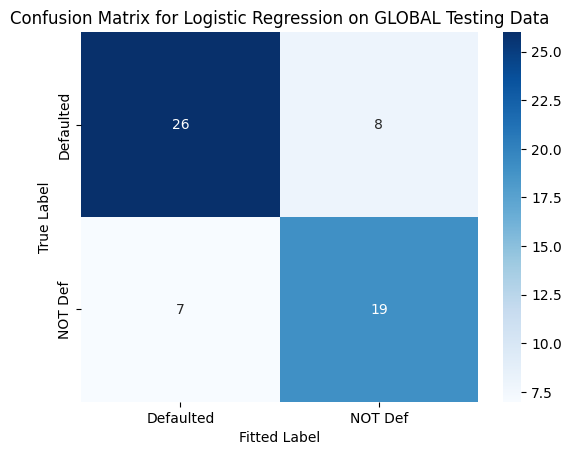

whole accuracy on the test set:  0.75


In [11]:
#plot the unique (global) test -performance
y_fitted_global_test = logistic_reg_global.predict(X_test)
cm_global_test = confusion_matrix(y_fitted_global_test,y_test)
sns.heatmap(cm_global_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Logistic Regression on GLOBAL Testing Data')
plt.xlabel("Fitted Label")
plt.ylabel("True Label")
plt.show()

#calculate the accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_fitted_global_test,y_test)
print("whole accuracy on the test set: ", accuracy_score(y_fitted_global_test,y_test))

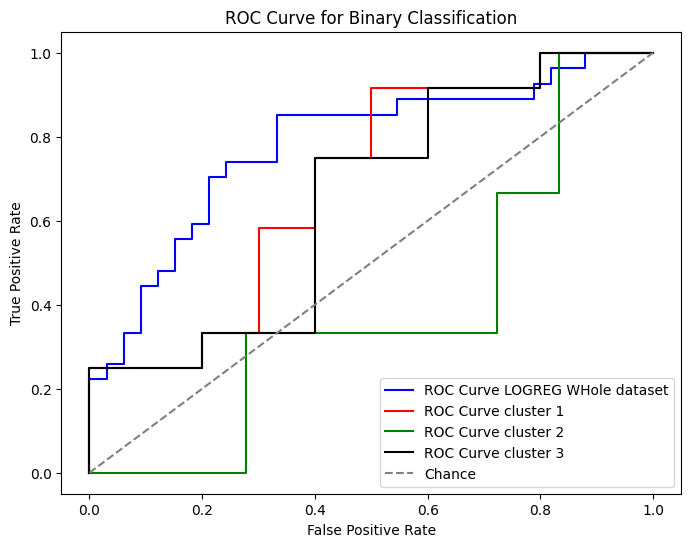

AUC score for LOGREG WHole dataset: 0.7800224466891134
AUC score for cluster 1: 0.6916666666666667
AUC score for cluster 2: 0.38888888888888884
AUC score for cluster 3: 0.6499999999999999


In [12]:
#AUC-ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

pred_prob = logistic_reg_global.predict_proba(X_test)[:,1] #to have only the probabilities of class 1

fpr, tpr, _ = roc_curve(y_test, pred_prob) #plotting TPR vs FPR by varying the threshold t

pred_prob1 = logistic_reg1.predict_proba(X_test_cluster1)[:,1] #to have only the probabilities of class 1

fpr1, tpr1, _ = roc_curve(y_test_cluster1, pred_prob1) #plotting TPR vs FPR by varying the threshold t


pred_prob2 = logistic_reg2.predict_proba(X_test_cluster2)[:,1] #to have only the probabilities of class 1

fpr2, tpr2, _ = roc_curve(y_test_cluster2, pred_prob2) #plotting TPR vs FPR by varying the threshold t

pred_prob3 = logistic_reg3.predict_proba(X_test_cluster3)[:,1] #to have only the probabilities of class 1

fpr3, tpr3, _ = roc_curve(y_test_cluster3, pred_prob3) #plotting TPR vs FPR by varying the t

#plot the 3 roc curves
# Plot the ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve LOGREG WHole dataset")
plt.plot(fpr1, tpr1, color='red', label=f"ROC Curve cluster 1")
plt.plot(fpr2, tpr2, color='green', label=f"ROC Curve cluster 2")
plt.plot(fpr3, tpr3, color='black', label=f"ROC Curve cluster 3")


# Plot the diagonal line representing random chance
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Chance")

# Labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Binary Classification")
plt.legend(loc="lower right")
plt.show()

#calculate the AUC scores
from sklearn.metrics import roc_auc_score

auc_logreg = roc_auc_score(y_test, pred_prob)
auc_cluster1 = roc_auc_score(y_test_cluster1, pred_prob1)
auc_cluster2 = roc_auc_score(y_test_cluster2, pred_prob2)
auc_cluster3 = roc_auc_score(y_test_cluster3, pred_prob3)


print(f"AUC score for LOGREG WHole dataset: {auc_logreg}")
print(f"AUC score for cluster 1: {auc_cluster1}")
print(f"AUC score for cluster 2: {auc_cluster2}")
print(f"AUC score for cluster 3: {auc_cluster3}")

In [13]:
#unique roc-auc (clusterings vs global)
# --- 1. PREPARAZIONE DATI PER IL MODELLO GLOBALE ---
# Calcola probabilità, AUC e curva ROC per il modello globale
pred_prob_global = logistic_reg_global.predict_proba(X_test)[:, 1]
auc_global = roc_auc_score(y_test, pred_prob_global)
fpr_global, tpr_global, _ = roc_curve(y_test, pred_prob_global)


# --- 2. PREPARAZIONE DATI PER IL SISTEMA A CLUSTER (ENSEMBLE) ---
# Ricostruiamo l'array delle probabilità per l'intero sistema a cluster
# Questo è il passo CRUCIALE per un confronto corretto

# Crea un array di zeri con la stessa lunghezza di y_test.
# Questo ci assicura di riempirlo mantenendo l'ordine corretto dei campioni.
pred_prob_ensemble = np.zeros_like(y_test, dtype=float)

# Mappe per accedere ai modelli e ai dati in modo programmatico
# (questo evita di scrivere codice ripetuto if/else)
models_dict = {0: logistic_reg1, 1: logistic_reg2, 2: logistic_reg3}
optimal_num_clusters = 3

for i in range(optimal_num_clusters):
    # Trova gli indici dei campioni di test che appartengono al cluster 'i'
    mask_test = (cluster_labels_test == i)

    # Se ci sono campioni in questo cluster
    if np.sum(mask_test) > 0:
        # Seleziona il sottoinsieme di X_test
        X_test_subset = X_test[mask_test]

        # Seleziona il modello corretto e calcola le probabilità
        model = models_dict[i]
        prob_subset = model.predict_proba(X_test_subset)[:, 1]

        # Inserisci le probabilità calcolate nell'array finale,
        # nelle posizioni corrispondenti ai campioni di questo cluster.
        pred_prob_ensemble[mask_test] = prob_subset

# Ora calcola AUC e curva ROC per l'intero sistema a cluster
auc_ensemble = roc_auc_score(y_test, pred_prob_ensemble)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, pred_prob_ensemble)


# --- 3. STAMPA DEI RISULTATI E CREAZIONE DEL GRAFICO FINALE ---

print("--- Risultati del Confronto AUC ---")
print(f"AUC Score - Modello Globale: {auc_global:.4f}")
print(f"AUC Score - Sistema a Cluster (Ensemble): {auc_ensemble:.4f}\n")


--- Risultati del Confronto AUC ---
AUC Score - Modello Globale: 0.7800
AUC Score - Sistema a Cluster (Ensemble): 0.6891



cluster 0  train accuracy: 1.0
cluster 1  train accuracy: 1.0
cluster 2  train accuracy: 1.0
cluster 0 test accuracy: 0.6923076923076923
cluster 1 test accuracy: 0.7727272727272727
cluster 2 test accuracy: 1.0
Overall accuracy: 0.8216783216783217
Logistic regression accuracy: 0.575


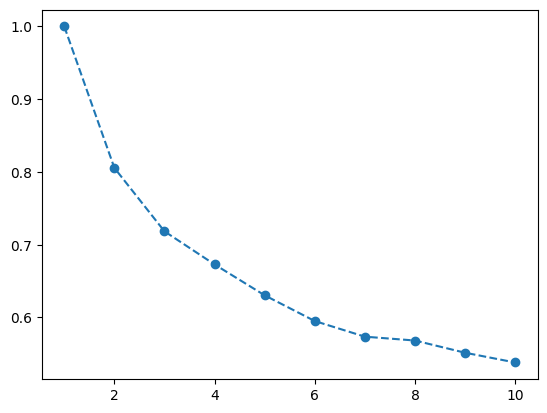

In [14]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Load df
CREDIT_PATH = 'credit_default.csv'
df = pd.read_csv(CREDIT_PATH)
df

#separate X and y
X = df.drop('default', axis=1) #all numerical features
y = df['default'] #target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234) #split df into train-test
#scaling
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

#using kmeans find the best k using variability ratio
wss_list = []
bss_list = []
x_vals = X_train.values
totalsum = np.sum( (x_vals - x_vals.mean(axis=0) )**2)
for k in range(1,11):
  kmeans = KMeans(n_clusters=k, random_state=42).fit(x_vals)
  WSS = kmeans.inertia_
  BSS = totalsum - WSS
  wss_list.append(WSS)
  bss_list.append(BSS)

ratio = np.array(wss_list) / (np.array(wss_list) + np.array(bss_list))
plt.plot(range(1,11), ratio, marker='o', linestyle='--')

#select the best k, fit the model and compute the labels
k = 3
kmeans = KMeans(n_clusters=k, random_state=42).fit(x_vals)
cluster_labels = kmeans.labels_

#divide in k sets based on the label
cluster_sets = [X_train[cluster_labels == i] for i in range(k)]
y_train_sets = [y_train[cluster_labels == i] for i in range(k)]
models = {}

#for each set fit a logistic regression
for i, (cluster_set, y_train_set) in enumerate(zip(cluster_sets,y_train_sets)):
  log_reg = LogisticRegression(penalty='l2', C = 1e13, solver= 'liblinear', max_iter = 1000)
  log_reg.fit(cluster_set, y_train_set)
  models[i] = log_reg
  print(f"cluster {i}  train accuracy: {log_reg.score(cluster_set, y_train_set)}")

# Assign test samples to clusters
test_cluster_labels = kmeans.predict(X_test)

#divide in based on the label
cluster_sets_test = [X_test[test_cluster_labels == i] for i in range(k)]
y_test_sets = [y_test[test_cluster_labels == i] for i in range(k)]

#compute the score
for i, (cluster_set_test, y_test_set) in enumerate(zip(cluster_sets_test,y_test_sets)):
  print(f"cluster {i} test accuracy: {models[i].score(cluster_set_test, y_test_set)}")

#compute overall accuracy accross clusters
overall_accuracy = np.mean([models[i].score(cluster_sets_test[i], y_test_sets[i]) for i in range(k)])
print(f"Overall accuracy: {overall_accuracy}")

#compute accuracy of the standard logistic regression used before
print(f"Logistic regression accuracy: {log_reg.score(X_test, y_test)}")